# Formative 3 - Probability Distributions, Bayesian Probability, and Gradient Descent Implementation

**Objectives:**

This assignment will deepen your understanding of probability distributions, Bayesian probability, and gradient descent. You will:

1. Implement key probability distributions in code and analyze their differences.

2. Apply Bayesian probability to a real-world problem.

3. Manual Calculation of Gradient Descent.

4. Implement gradient descent for linear regression in Python using the SciPy library.

## Part 1: Normal Distribution

**Problem:**

The battery life of computers follows a normal distribution with mean (μ) = 24 hours and standard deviation (σ) = 3 hours.

Smartphone Battery Life Analysis using Normal Distribution
--------------------------------------------------------
Assuming battery life follows a normal distribution with:
Mean (μ) = 24 hours
Standard Deviation (σ) = 3 hours

Probability battery lasts < 20 hours: 9.12%
Probability battery lasts > 30 hours: 2.28%
Probability battery lasts between 22-26 hours: 49.50%


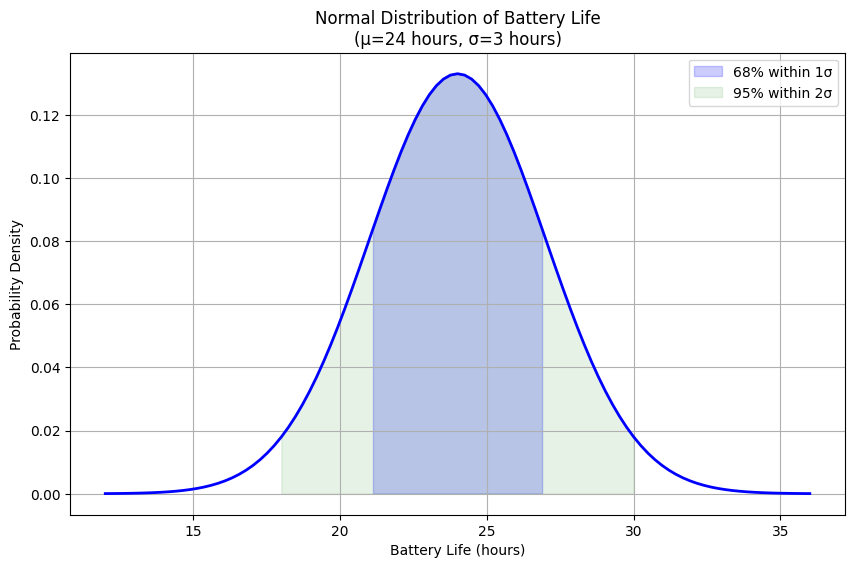

In [1]:
import math
import matplotlib.pyplot as plt

class NormalDistribution:
    """
    A class to handle normal distribution calculations.
    """

    @staticmethod
    def pdf(x, mean, std_dev):
        """
        Calculate the probability density function for normal distribution.
        """
        exponent = -((x - mean) ** 2) / (2 * std_dev ** 2)
        return (1 / (std_dev * math.sqrt(2 * math.pi))) * math.exp(exponent)

    @staticmethod
    def cdf(x, mean, std_dev):
        """
        Calculate the cumulative distribution function using the error function approximation.
        This implements the Abramowitz and Stegun approximation of the normal CDF.
        """
        z = (x - mean) / std_dev
        t = 1 / (1 + 0.2316419 * abs(z))
        d = 0.3989423 * math.exp(-z * z / 2)
        prob = d * t * (0.3193815 + t * (-0.3565638 + t * (1.781478 + t * (-1.821256 + t * 1.330274))))

        if z > 0:
            return 1 - prob
        else:
            return prob

    @staticmethod
    def probability_between(x1, x2, mean, std_dev):
        """
        Calculate the probability between two values.
        """
        return abs(NormalDistribution.cdf(x2, mean, std_dev) - NormalDistribution.cdf(x1, mean, std_dev))

def plot_normal_distribution(mean, std_dev, min_x, max_x):
    """
    Plot the normal distribution curve using matplotlib.
    """
    # Generate points for the x-axis
    step = (max_x - min_x) / 100
    x_values = [min_x + i * step for i in range(101)]
    y_values = [NormalDistribution.pdf(x, mean, std_dev) for x in x_values]

    plt.figure(figsize=(10, 6))
    plt.plot(x_values, y_values, 'b-', linewidth=2)
    plt.title(f'Normal Distribution of Battery Life\n(μ={mean} hours, σ={std_dev} hours)')
    plt.xlabel('Battery Life (hours)')
    plt.ylabel('Probability Density')
    plt.grid(True)

    # Shade areas under the curve for probabilities
    plt.fill_between(x_values, y_values, where=[(x >= mean - std_dev and x <= mean + std_dev) for x in x_values],
                     color='blue', alpha=0.2, label='68% within 1σ')
    plt.fill_between(x_values, y_values, where=[(x >= mean - 2*std_dev and x <= mean + 2*std_dev) for x in x_values],
                     color='green', alpha=0.1, label='95% within 2σ')

    plt.legend()
    plt.show()

def main():
    """
    Main function to analyze smartphone battery life using normal distribution.
    """
    print("Smartphone Battery Life Analysis using Normal Distribution")
    print("--------------------------------------------------------")

    # Real-world example: Smartphone battery life (hours)
    mean_battery_life = 24  # average battery life in hours
    std_dev = 3             # standard deviation in hours

    print(f"Assuming battery life follows a normal distribution with:")
    print(f"Mean (μ) = {mean_battery_life} hours")
    print(f"Standard Deviation (σ) = {std_dev} hours\n")

    # Calculate some probabilities
    # Probability that battery lasts less than 20 hours
    prob_less_20 = NormalDistribution.cdf(20, mean_battery_life, std_dev)
    print(f"Probability battery lasts < 20 hours: {prob_less_20:.2%}")

    # Probability that battery lasts more than 30 hours
    prob_more_30 = 1 - NormalDistribution.cdf(30, mean_battery_life, std_dev)
    print(f"Probability battery lasts > 30 hours: {prob_more_30:.2%}")

    # Probability that battery lasts between 22 and 26 hours
    prob_between_22_26 = NormalDistribution.probability_between(22, 26, mean_battery_life, std_dev)
    print(f"Probability battery lasts between 22-26 hours: {prob_between_22_26:.2%}")

    # Plot the distribution
    plot_normal_distribution(mean_battery_life, std_dev, mean_battery_life - 4*std_dev, mean_battery_life + 4*std_dev)

if __name__ == "__main__":
    main()

## Part 2: Bayesian Probability

**Scenario:**

- Breast cancer prevalence: 1% of women (prior probability)
- Mammogram sensitivity (True Positive Rate): 90%
- Mammogram specificity (True Negative Rate): 91%
- False Positive Rate: 9%

**Question:** What is the probability a woman actually has breast cancer if she tests positive on a mammogram?


=== Bayesian Update for Breast Cancer Diagnosis ===
Prevalence (Prior P(Cancer)): 0.0100 (1.0%)
Sensitivity (True Positive Rate): 0.90
Specificity (True Negative Rate): 0.91

P(Positive | Cancer) * P(Cancer) = 0.9 * 0.01 = 0.0090
P(Positive | No Cancer) * P(No Cancer) = 0.09 * 0.9900 = 0.0891

P(Positive) = 0.0090 + 0.0891 = 0.0981

Posterior Probability P(Cancer | Positive) = 0.0090 / 0.0981 ≈ 0.0917 (9.2%)

**Conclusion:** Even with a positive mammogram, there's only a ~9.17% chance the patient actually has breast cancer due to low prevalence and false positives.


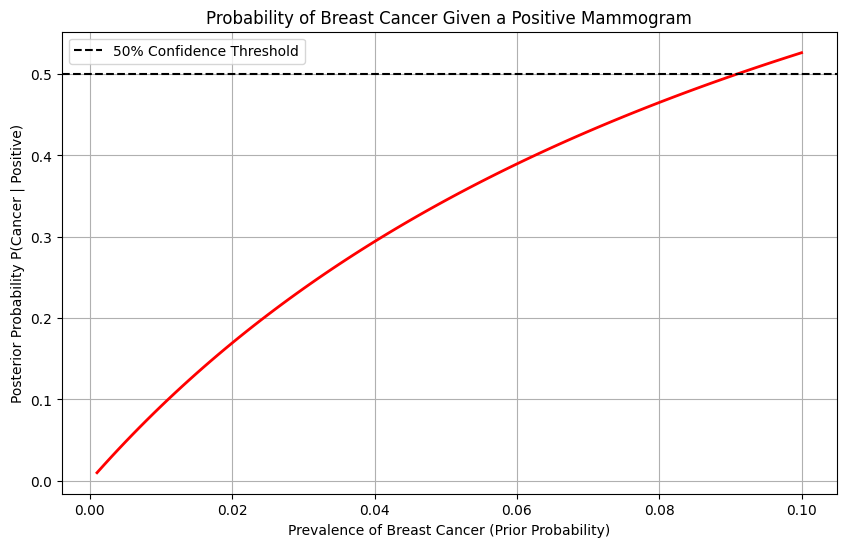

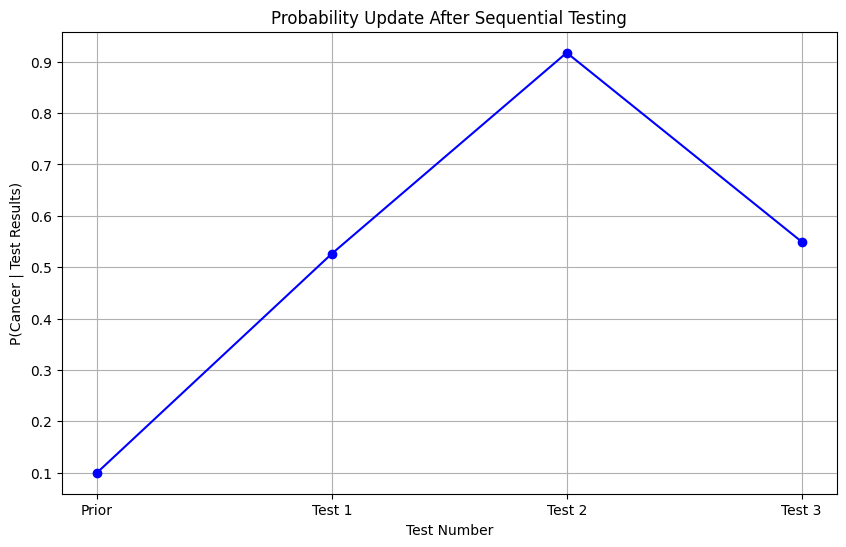

Updated probabilities after each test: ['10.00%', '52.63%', '91.74%', '54.98%']


In [9]:
import numpy as np
import matplotlib.pyplot as plt

class BayesianBreastCancerDiagnosis:
    def __init__(self):
        # Initial probabilities
        self.prevalence = 0.01  # 1% of women have breast cancer (prior)
        self.sensitivity = 0.90  # 90% true positive rate (mammogram detects cancer if present)
        self.specificity = 0.91  # 91% true negative rate (mammogram correctly rules out cancer)

    def calculate_posterior(self, prior=None):
        """Calculate P(Cancer | Positive Mammogram) using Bayes' Theorem."""
        if prior is not None:
            self.prevalence = prior

        # P(Positive | Cancer) * P(Cancer)
        true_positives = self.sensitivity * self.prevalence

        # P(Positive | No Cancer) * P(No Cancer)
        false_positives = (1 - self.specificity) * (1 - self.prevalence)

        # P(Positive) = P(Positive | Cancer) + P(Positive | No Cancer)
        p_positive = true_positives + false_positives

        # Bayes' Theorem: P(Cancer | Positive) = P(Positive | Cancer) * P(Cancer) / P(Positive)
        posterior = true_positives / p_positive

        return posterior

    def plot_posterior_vs_prevalence(self):
        """Visualize how posterior probability changes with disease prevalence."""
        prevalence_values = np.linspace(0.001, 0.1, 100)  # 0.1% to 10% prevalence
        posteriors = [self.calculate_posterior(p) for p in prevalence_values]

        plt.figure(figsize=(10, 6))
        plt.plot(prevalence_values, posteriors, color='red', linewidth=2)
        plt.title("Probability of Breast Cancer Given a Positive Mammogram")
        plt.xlabel("Prevalence of Breast Cancer (Prior Probability)")
        plt.ylabel("Posterior Probability P(Cancer | Positive)")
        plt.grid(True)
        plt.axhline(y=0.5, color='black', linestyle='--', label="50% Confidence Threshold")
        plt.legend()
        plt.show()

    def sequential_testing(self, test_results):
        """Update belief after multiple tests (e.g., second mammogram or biopsy)."""
        current_prior = self.prevalence
        probabilities = [current_prior]

        for result in test_results:
            if result == 'positive':
                likelihood = self.sensitivity
                false_positive_rate = 1 - self.specificity
            else:
                likelihood = 1 - self.sensitivity  # False negative
                false_positive_rate = self.specificity  # True negative

            # Bayes update
            numerator = likelihood * current_prior
            denominator = numerator + false_positive_rate * (1 - current_prior)
            current_prior = numerator / denominator
            probabilities.append(current_prior)

        # Plot results
        plt.figure(figsize=(10, 6))
        plt.plot(probabilities, marker='o', linestyle='-', color='blue')
        plt.title("Probability Update After Sequential Testing")
        plt.xlabel("Test Number")
        plt.ylabel("P(Cancer | Test Results)")
        plt.xticks(range(len(probabilities)), ['Prior'] + [f'Test {i+1}' for i in range(len(test_results))])
        plt.grid(True)
        plt.show()

        return probabilities

    def explain_bayesian_update(self):
        """Step-by-step explanation of Bayes' Theorem in this context."""
        print("\n=== Bayesian Update for Breast Cancer Diagnosis ===")
        print(f"Prevalence (Prior P(Cancer)): {self.prevalence:.4f} ({self.prevalence*100}%)")
        print(f"Sensitivity (True Positive Rate): {self.sensitivity:.2f}")
        print(f"Specificity (True Negative Rate): {self.specificity:.2f}\n")

        # P(Positive | Cancer) * P(Cancer)
        true_positives = self.sensitivity * self.prevalence
        print(f"P(Positive | Cancer) * P(Cancer) = {self.sensitivity} * {self.prevalence} = {true_positives:.4f}")

        # P(Positive | No Cancer) * P(No Cancer)
        false_positives = (1 - self.specificity) * (1 - self.prevalence)
        print(f"P(Positive | No Cancer) * P(No Cancer) = {1 - self.specificity:.2f} * {1 - self.prevalence:.4f} = {false_positives:.4f}")

        # P(Positive) = P(Positive | Cancer) + P(Positive | No Cancer)
        p_positive = true_positives + false_positives
        print(f"\nP(Positive) = {true_positives:.4f} + {false_positives:.4f} = {p_positive:.4f}")

        # P(Cancer | Positive) = [P(Positive | Cancer) * P(Cancer)] / P(Positive)
        posterior = true_positives / p_positive
        print(f"\nPosterior Probability P(Cancer | Positive) = {true_positives:.4f} / {p_positive:.4f} ≈ {posterior:.4f} ({posterior*100:.1f}%)")

        print("\n**Conclusion:** Even with a positive mammogram, there's only a ~9.17% chance the patient actually has breast cancer due to low prevalence and false positives.")

# Example Usage
if __name__ == "__main__":
    diagnosis = BayesianBreastCancerDiagnosis()

    # Step-by-step Bayesian update explanation
    diagnosis.explain_bayesian_update()

    # Visualize how posterior changes with prevalence
    diagnosis.plot_posterior_vs_prevalence()

    # Sequential testing (e.g., second mammogram or biopsy)
    test_results = ['positive', 'positive', 'negative']  # Two positives, then a negative
    probabilities = diagnosis.sequential_testing(test_results)
    print(f"Updated probabilities after each test: {[f'{p*100:.2f}%' for p in probabilities]}")

## Part 3: Gradient Descent Manual Calculation

**Problem:**

Implement gradient descent manual calculation to fit a linear model of the two points (1,2) and (2,3).


### Manual Calculations

**Summary:**

| Iteration  |     m     |     b     |
|------------|-----------|-----------|
| Initially  | -1        | 1         |
| 1          |  1.7      | 2.1       |
| 2          |  1.26     | 1.9       |
| 3          |  1.34     | 1.916     |
| 4          |  1.3336   | 1.8968    |

## Part 4: Gradient Descent in Code

**Problem:**

Implement gradient descent in code to fit a linear model of the two points (1,2) and (2,3).


Iteration 1:
  x = 1, y = 3, ŷ = 0.0000, error = 3.0000
  x = 3, y = 6, ŷ = -2.0000, error = 8.0000
  MSE = 36.5000
  ∂J/∂m = -27.0000, ∂J/∂b = -11.0000
  Updated m = 1.7000, Updated b = 2.1000
----------------------------------------
Iteration 2:
  x = 1, y = 3, ŷ = 3.8000, error = -0.8000
  x = 3, y = 6, ŷ = 7.2000, error = -1.2000
  MSE = 1.0400
  ∂J/∂m = 4.4000, ∂J/∂b = 2.0000
  Updated m = 1.2600, Updated b = 1.9000
----------------------------------------
Iteration 3:
  x = 1, y = 3, ŷ = 3.1600, error = -0.1600
  x = 3, y = 6, ŷ = 5.6800, error = 0.3200
  MSE = 0.0640
  ∂J/∂m = -0.8000, ∂J/∂b = -0.1600
  Updated m = 1.3400, Updated b = 1.9160
----------------------------------------
Iteration 4:
  x = 1, y = 3, ŷ = 3.2560, error = -0.2560
  x = 3, y = 6, ŷ = 5.9360, error = 0.0640
  MSE = 0.0348
  ∂J/∂m = 0.0640, ∂J/∂b = 0.1920
  Updated m = 1.3336, Updated b = 1.8968
----------------------------------------
Final Predictions:
  For x = 1, ŷ = 3.2304
  For x = 3, ŷ = 5.89

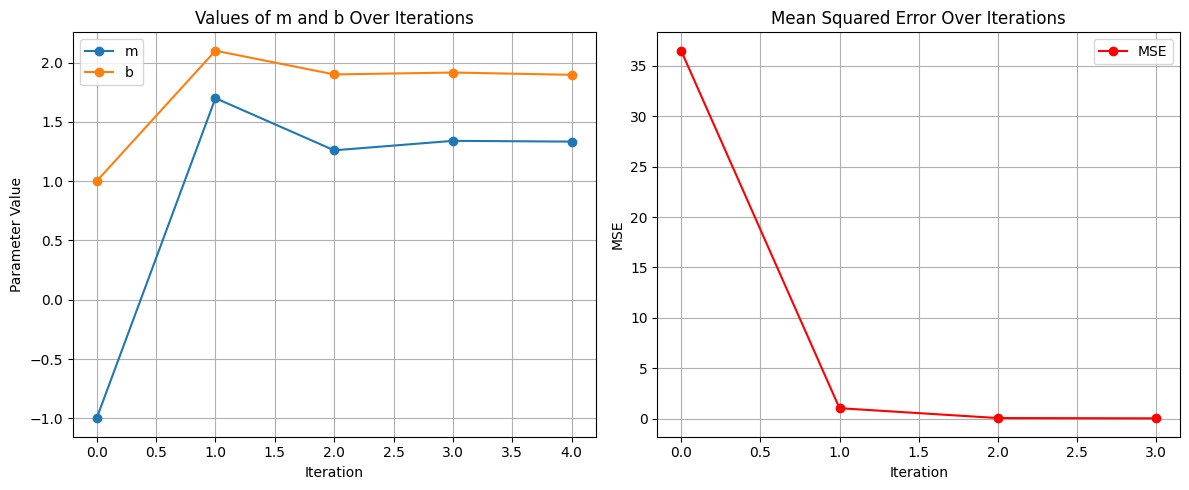

In [ ]:
import matplotlib.pyplot as plt

# Step 0: Initial setup
m = -1
b = 1
alpha = 0.1
data = [(1, 3), (3, 6)]
n = len(data)

# Tracking for plotting
m_values = [m]
b_values = [b]
errors = []

# Step-by-step gradient descent
for step in range(4):
    # Step 1: Compute predictions and errors
    y_hats = []
    total_error = 0
    grad_m = 0
    grad_b = 0

    print(f"Iteration {step + 1}:")

    for x, y in data:
        y_hat = m * x + b
        y_hats.append(y_hat)
        error = y - y_hat
        total_error += error ** 2
        grad_m += -2 * x * error
        grad_b += -2 * error
        print(f"  x = {x}, y = {y}, ŷ = {y_hat:.4f}, error = {error:.4f}")

    # Step 2: Compute MSE
    mse = total_error / n
    errors.append(mse)

    print(f"  MSE = {mse:.4f}")

    # Step 3: Compute gradients
    grad_m /= n
    grad_b /= n
    print(f"  ∂J/∂m = {grad_m:.4f}, ∂J/∂b = {grad_b:.4f}")

    # Step 4: Update m and b
    m = m - alpha * grad_m
    b = b - alpha * grad_b

    print(f"  Updated m = {m:.4f}, Updated b = {b:.4f}")
    print("-" * 40)

    # Save values for plotting
    m_values.append(m)
    b_values.append(b)

# Step 5: Final prediction using updated m and b
final_predictions = [m * x + b for x, _ in data]
print("Final Predictions:")
for i, (x, _) in enumerate(data):
    print(f"  For x = {x}, ŷ = {final_predictions[i]:.4f}")

# Step 6: Plotting m, b, and error
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
iterations = list(range(5))

ax1.plot(iterations, m_values, label='m', marker='o')
ax1.plot(iterations, b_values, label='b', marker='o')
ax1.set_title('Values of m and b Over Iterations')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Parameter Value')
ax1.legend()
ax1.grid(True)

ax2.plot(iterations[:-1], errors, label='MSE', marker='o', color='red')
ax2.set_title('Mean Squared Error Over Iterations')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('MSE')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

**Group Contributions:**

- Kellen worked on **pdf**(Part 1), __init__ function(Part 2), **Iteration 2**(Part 3, Part 4).
- Erneste worked on **cdf**(Part 1), **calculate_posterior** function(Part 2), **Iteration 1**(Part 3, Part 4).
- Pauline worked on **probability_between** function(Part 1), **plot_posterior_vs_prevalence** function(Part 2), **Iteration 4**(Part 3, Part 4).
- Souvede worked on **plot_normal_distribution** function(Part 1), **sequential_testing & explain_bayesian_update** functions(Part 2), **Iteration 3**(Part 3, Part 4).
